In [26]:
import torch
import torch.nn as nn
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms
import cv2
import csv

import lightning
from lightning.pytorch.loggers import TensorBoardLogger

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

import matplotlib.patches as mpatches
from torchvision.transforms import InterpolationMode

from torchvision.transforms import CenterCrop

In [27]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [28]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [29]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(1)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 11811160064
free     : 11328421888
used     : 482738176


In [30]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [31]:
plt.style.use('Solarize_Light2')

## Датасет и Dataloaders

Датасет будет выдавать две картинки: маску и само изображение
где маска рисуется средствами cv2 по 4м точкам, которые заданы восемью колонками в `markup.csv`

In [32]:
tr_pt   = Path('../CourseOCRTask3/Train/Images').resolve()
test_pt = Path('../CourseOCRTask3/Test/Images').resolve()
mark_pt = Path('../CourseOCRTask3/Train/markup.csv').resolve()

assert tr_pt.exists(), test_pt.exists()

print(test_pt)

/home/krapchatovmi/jupyter/ML/CourseOCRTask3/Test/Images


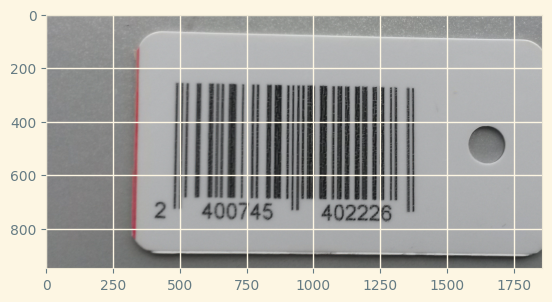

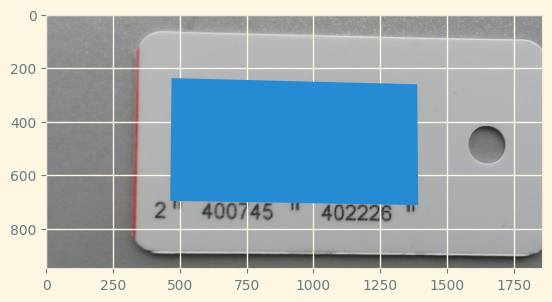

In [33]:
rws = list(csv.reader(open(mark_pt, 'r', encoding='utf-16')))
line = rws[4]

img = cv2.cvtColor(cv2.imread(f'{tr_pt}/{line[0]}'), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

fig, ax = plt.subplots()
ax.imshow(img)

cnt = np.array([(line[2 * i], line[2 * i + 1]) for i in range(1, 5)], dtype=int)
ax.add_patch(mpatches.Polygon(cnt))
plt.show()

In [34]:
class BarcodeDS(Dataset):
    def __init__(self, train_paths, shape=(256, 256), isTrain=True):
        self.train_paths = train_paths
        self.compressed_shape = shape
        self.isTrain=isTrain

    def __len__(self):
        return len(self.train_paths)

    # Preprocessing of the image
    def processImg(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.array(img)
        img = transforms.ToTensor()(img)
        return img

    # Creating the mask of the image
    def createMsk(self, img, dt):
        mask = np.zeros(img.size()[1:])
        # Make the mask
        cv2.fillConvexPoly(mask, np.array([[dt[2 * i], dt[2 * i + 1]] for i in range(1, 5)],dtype=int), 1)
        mask = torch.FloatTensor(mask).unsqueeze(0)
        # Resize the mask to the standard size
        mask = transforms.Resize((256, 256), interpolation=InterpolationMode.NEAREST)(mask)
        return mask

    # Get image function from the dataset
    def __getitem__(self, idx):
        dt = self.train_paths[idx]
        img = cv2.imread(str(dt[0]))
        img = self.processImg(img)
        mask = self.createMsk(img, dt)
        # Compress the image
        img = transforms.Resize((256, 256))(img)

        return img, mask

['/home/krapchatovmi/jupyter/ML/CourseOCRTask3/Train/Images/fc272e4092ccb147a31e66bc1d10fbfb.png', '3601514743345', '538', '248', '1590', '225', '1597', '663', '532', '676', '10101011110001101011001101110010110011010001101010100010010111001000010100001010111001001110101']
train sz:6560 + test sz:1639 = 8199


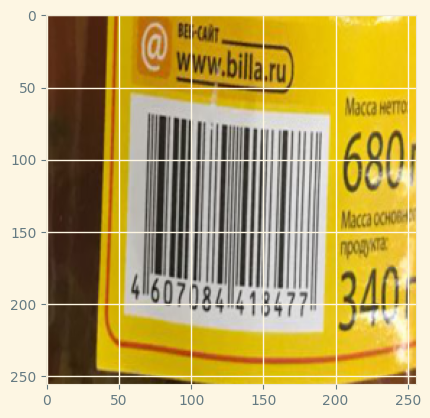

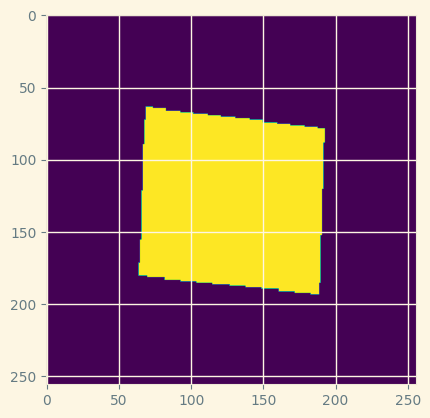

In [35]:
train_info = []
rws = list(csv.reader(open(mark_pt, 'r', encoding='utf-16')))

# Read whole the csv into the variable
# and conver to list
for line in rws:
    line[0] = tr_pt.joinpath(line[0])
    if line[0].exists() and str(line[0]).endswith('.png'):
        line[0] = str(line[0])
        train_info.append(list(line))

print(train_info[0])
train_dataset, val_dataset = torch.utils.data.random_split(BarcodeDS(train_info), lengths=[0.8, 0.2])
bsz = 16
train_dataloader = DataLoader(train_dataset, bsz, shuffle=True, num_workers=4)
val_dataloader   = DataLoader(val_dataset, bsz, shuffle=False, num_workers=4)

print(f"train sz:{len(train_dataset)} + test sz:{len(val_dataset)} = {len(train_info)}")
assert(len(train_dataset)+len(val_dataset)+len(train_info))

probe_idx = 23

img, mask = train_dataset[probe_idx]
plt.imshow(img.cpu().permute(1, 2, 0))
plt.show()
plt.imshow(mask.cpu().permute(1, 2, 0))
plt.show()

In [37]:
def upBlock(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
def nearest2d(channels):
    return nn.Sequential(
        nn.UpsamplingNearest2d(scale_factor=2),
        nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    )

def dDown(in_channels, out1, out2):
    return nn.Sequential(
        nn.Conv2d(in_channels, out1, kernel_size=3, padding=1),
        nn.BatchNorm2d(out1),
        nn.ReLU(),
        nn.Conv2d(out1, out2, kernel_size=3, padding=1),
        nn.BatchNorm2d(out2),
        nn.ReLU()
    )

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Up0 = upBlock(3,64)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Up1 = upBlock(64,128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Up2 = upBlock(128,256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Up3 = upBlock(256,512)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.near0 = nearest2d(512)
        self.Down0 = dDown(1024, 512, 256)
        
        self.near1 = nearest2d(256)
        self.Down1 = dDown(512, 256, 128)
        
        self.near2 = nearest2d(128)
        self.Down2 = dDown(256, 128, 64)
        
        self.near3 = nearest2d(64)
        self.Down3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )
        # self.cropping = CenterCrop(res.shape[2:4])
        self.img_compressor = nn.Upsample(scale_factor=0.5, mode='nearest')
        self.img_impressor = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        x1 = self.Up0(x)
        x1 = self.pool0(x1)
        # print(f'res.shape={x1.shape}')

        x2 = self.Up1(x1)
        x2 = self.pool1(x2)
        # print(f'res.shape={x2.shape}')

        x3 = self.Up2(x2)
        x3 = self.pool2(x3)
        # print(f'res.shape={x3.shape}')

        x4 = self.Up3(x3)
        x4 = self.pool3(x4)
        # print(f'res.shape={x4.shape}')
        b = self.bottleneck_conv(x4)

        res = self.near0(b)
        res = self.img_compressor(res)
        res = torch.cat((res, x4), dim=1)
        res = self.Down0(res)
        
        res = self.near1(res)
        res = torch.cat((res, x3), dim=1)
        res = self.Down1(res)
        
        res = self.near2(res)
        res = torch.cat((res, x2), dim=1)
        res = self.Down2(res)
        
        res = self.near3(res)
        res = torch.cat((res, x1), dim=1)
        res = self.Down3(res)
        res = self.img_impressor(res)
        
        return res

In [38]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, pred, trg):
        pred = pred.view(-1)
        trg = trg.view(-1)

        U = torch.sum(pred) + torch.sum(trg)
        I = torch.sum(pred * trg)
        
        dsc = (2. * I + 1.0) / (U + 1.0)
        return 1 - dsc

In [39]:
class UnetTrainer(lightning.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.criterion = DiceLoss()
        self.model = model
        
    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.model(inputs)
        outputs = torch.sigmoid(outputs)
        loss = self.criterion(outputs, targets)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.model(inputs)
        outputs = torch.sigmoid(outputs)
        loss = self.criterion(outputs, targets)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.model.parameters(), lr=1e-3)
        return optimizer

In [40]:
model = UNet().to(device)

In [15]:
# x,y = next(iter(train_dataloader))
# pred = model(x)

In [41]:
print(device)

lit_model = UnetTrainer(model).to(device)
trainer = lightning.Trainer(max_epochs=1)
trainer.fit(lit_model, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name      | Type     | Params
---------------------------------------
0 | criterion | DiceLoss | 0     
1 | model     | UNet     | 25.1 M
---------------------------------------
25.1 M    Trainable params
0         Non-trainable params
25.1 M    Total params
100.342   Total estimated model params size (MB)


cuda:0


Sanity Checking: |                                                                | 0/? [00:00<?, ?it/s]

Training: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                     | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [42]:
def corners(mask):
    mask = (mask.cpu().detach().numpy() > 0.5).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(contour)
    return np.array([x, y + h, x, y, x + w, y, x + w, y + h])

In [43]:
from tqdm import tqdm

In [44]:
print(test_pt)

/home/krapchatovmi/jupyter/ML/CourseOCRTask3/Test/Images


In [45]:
!ls '/home/krapchatovmi/jupyter/ML/CourseOCRTask3/Test/Images'

00f3d3d8b60ef559304ff51cadaf4fb1.png  97376e1b07bd92b927f4e8508fda19a2.png
021e9179bdd3287d873de5208535b4a7.png  97b2e27686dbb54b20cfbf9696d430f1.png
065c4a67725752b09302b0a6a5ad3971.png  99a0962609cf1f72e6990b0d1c8cf3fe.png
099574d0f797fe2519686fd1e724ebf3.png  9f627a286049886c0f3232a2469b3cc9.png
10c9065a00b9bea9b741208b2679cf76.png  a154b624c06072da1a01c97ebc3894c1.png
1105913212699e2e8a558191113acbd7.png  a417bfe1b2ea0e2ac15c92db789ff500.png
144b3c6678312a8dddaaa713c9f56a71.png  a6522bc3e9d7207451c564c3bb4a89b8.png
157a4b17084b43ef3b572dd7267e76d0.png  a6e233ce71def579f34570953163d255.png
16cd16966b3339632b8dbce36225237c.png  a7f9f2ac26ac6d10009611e290adb470.png
19b01a2c6deeda40dbbdc6c54b7b6497.png  aa43c03597169dc7c6b5c41c47f7e0ad.png
1b40467bc7b1623a8c957719fcf61b54.png  aab7bd3438de5ce40c4c7de3db0ecf23.png
1cd72c7dcf77e1b8a401c0a7b41573c8.png  ab30ca615e3fb75d5bcbf0b1aa663f69.png
2927ce6ceccad5fab23e5b332894c5e1.png  ad33d4cb49ac5a476768dd96b6eed78e.png
2bc877416a54aea8a94227ce9

In [ ]:
answer = []

model.eval()
with torch.no_grad():
    for file in tqdm(os.listdir(test_pt)):
        fname = f'{test_pt}/{file}'
        if fname.endswith('.png'):
            image = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
            shape = image.shape[:2]
            image = transforms.ToTensor()(image)
            img = transforms.Resize((256,256))(img)
            msk = model(img.unsqueeze(0))
            msk = transforms.Resize(shape, interpolation=Image.NEAREST)(msk)
            answer.append([file, corners(msk.squeeze())])

 86%|████████████████████████████████████████████████████████▊         | 87/101 [02:13<00:02,  5.30it/s]

In [24]:
with open('answer.csv', mode='w', encoding='utf-16') as file:
    for i in range(len(answer)):
        file.write(answer[i][0] + ',-,' + ','.join([str(val) for val in answer[i][1]]) + ',-\n')

In [25]:
from course_intro_ocr_t3.evaluate import main

main()

Checking answer (/home/krapchatovmi/jupyter/ML/task3/answer.csv) against markup(/home/krapchatovmi/jupyter/ML/task3/markup.csv)
recognition_accuracy=0.0
detection_result=0.86
score=0.86


In [ ]:
!cat answer.csv